In [1]:
# utilities
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load the data
df=pd.read_csv("datasheet_guvi_courses.csv")
df.head()

,course_id,course_title,url,price,num_subscribers,num_reviews,num_lectures,level,Rating,content_duration,published_timestamp,subject
0,41295.0,Learn HTML5 Programming From Scratch,https://www.udemy.com/learn-html5-programming-...,0.0,268923.0,8629.0,45.0,Beginner Level,0.82,10.5,2013-02-14T07:03:41Z,Subject: Web Development
1,59014.0,Coding for Entrepreneurs Basic,https://www.udemy.com/coding-for-entrepreneurs...,0.0,161029.0,279.0,27.0,Expert Level,0.69,3.5,2013-06-09T15:51:55Z,Subject: Web Development
2,625204.0,The Web Developer Bootcamp,https://www.udemy.com/the-web-developer-bootcamp/,200.0,121584.0,27445.0,342.0,Beginner Level,0.89,43.0,2015-11-02T21:13:27Z,Subject: Web Development
3,173548.0,Build Your First Website in 1 Week with HTML5 ...,https://www.udemy.com/build-your-first-website...,0.0,120291.0,5924.0,30.0,All Levels,0.78,3.0,2014-04-08T16:21:30Z,Subject: Web Development
4,764164.0,The Complete Web Developer Course 2.0,https://www.udemy.com/the-complete-web-develop...,200.0,114512.0,22412.0,304.0,Beginner Level,0.55,30.5,2016-03-08T22:28:36Z,Subject: Web Development


In [3]:
# Understand the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3676 non-null   float64
 1   course_title         3676 non-null   object 
 2   url                  3676 non-null   object 
 3   price                3676 non-null   float64
 4   num_subscribers      3676 non-null   float64
 5   num_reviews          3676 non-null   float64
 6   num_lectures         3676 non-null   float64
 7   level                3676 non-null   object 
 8   Rating               3676 non-null   float64
 9   content_duration     3676 non-null   float64
 10  published_timestamp  3676 non-null   object 
 11  subject              3677 non-null   object 
dtypes: float64(7), object(5)
memory usage: 345.1+ KB


In [4]:
# Checking if there are any NULL Values
df.isnull().sum()

course_id              4
course_title           4
url                    4
price                  4
num_subscribers        4
num_reviews            4
num_lectures           4
level                  4
Rating                 4
content_duration       4
published_timestamp    4
subject                3
dtype: int64

In [5]:
# It seems that the null values are for the same rows.
df[df['course_id'].isna()]

,course_id,course_title,url,price,num_subscribers,num_reviews,num_lectures,level,Rating,content_duration,published_timestamp,subject
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Subject: Web Development
2490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# We can drop them.
df.dropna(subset=['course_id'],inplace=True)

In [7]:
# Understand the data
df.describe(include='O')

,course_title,url,level,published_timestamp,subject
count,3676,3676,3676,3676,3676
unique,3663,3672,4,3672,4
top,Creating an animated greeting card via Google ...,https://www.udemy.com/make-your-own-business-w...,All Levels,2014-06-23T16:03:41Z,Subject: Web Development
freq,3,2,1925,2,1203


In [8]:
# Dropping unnecessary columns
# Since Course_Title, URL & TimeStamp have large number of Categories for a small dataset. We drop them,
# as when we encode them will generate a large number of dummy columns and thus will have a weak co-relation with target. 
df.drop(columns=["course_title"], inplace=True)
df.drop(columns=["url"], inplace=True)
df.drop(columns=["published_timestamp"], inplace=True)
# Since Course ID will not have any impct on the traget we can drop the same.
df.drop(columns=["course_id"], inplace=True)

In [9]:
# Function to transform Numeric Variables
def transVariable(coln, df):
    from sklearn.preprocessing import FunctionTransformer
    log_transform = FunctionTransformer(np.log, validate=True)
    cols=[coln]
    df[cols] = log_transform.transform(df[cols])
    plt.hist(df[cols])

In [10]:
# Function to detect Outliers
def outlier_detection(coln):
    Q1 = np.percentile(coln, 25,interpolation = 'midpoint')
    Q3 = np.percentile(coln, 75,interpolation = 'midpoint')
    IQR = Q3 - Q1
    upper = coln >= (Q3+1.5*IQR)
    outlier=list(np.where(upper)[0])
    lower = coln <= (Q1-1.5*IQR)
    for each in list(np.where(lower)[0]):
        if each not in outlier:
            outlier.append(each)
    print("Outlier Count:", len(outlier))

In [11]:
# Function Outlier deletion
indices = []
def outlier_delete(coln):
    Q1 = np.percentile(coln, 25, interpolation = 'midpoint')
    Q3 = np.percentile(coln, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    upper = coln >= (Q3+1.5*IQR) 
    lower = coln <= (Q1-1.5*IQR)
    upp=[]
    for i in list(upper.index):
        if upper[i]==True:
            upp.append(i)
    for i in upp:
        df.drop(i,inplace=True)
    low=[]
    for i in list(lower.index):
        if lower[i]==True:
            low.append(i)
    for i in low:
        df.drop(i,inplace=True)

(array([3.618e+03, 3.300e+01, 1.600e+01, 4.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([     0. ,  26892.3,  53784.6,  80676.9, 107569.2, 134461.5,
        161353.8, 188246.1, 215138.4, 242030.7, 268923. ]),
 <BarContainer object of 10 artists>)

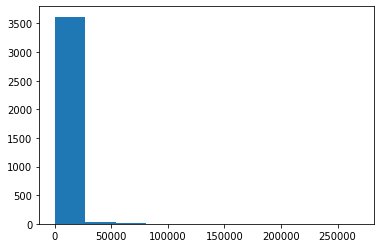

In [12]:
# address outliers in num_subscribers
plt.hist(df['num_subscribers'])
# we are not able to transform them, hence we will leave it.

(array([3.649e+03, 1.100e+01, 7.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([    0. ,  2744.5,  5489. ,  8233.5, 10978. , 13722.5, 16467. ,
        19211.5, 21956. , 24700.5, 27445. ]),
 <BarContainer object of 10 artists>)

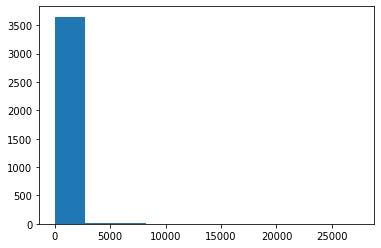

In [13]:
# address outliers in num_reviews
plt.hist(df['num_reviews'])
# we are not able to transform them, hence we will leave it.

(array([3.269e+03, 3.030e+02, 5.500e+01, 2.100e+01, 1.600e+01, 7.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  77.9, 155.8, 233.7, 311.6, 389.5, 467.4, 545.3, 623.2,
        701.1, 779. ]),
 <BarContainer object of 10 artists>)

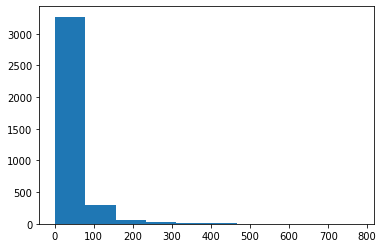

In [14]:
# address outliers in num_lectures
plt.hist(df['num_lectures'])
# we are not able to transform them, hence we will leave it.

In [15]:
# Get the Traget variable seperately
y = df['Rating']

In [16]:
# Code to get categorical data seperately, so as to understand their impact on the traget variabel
categorical_data = df.select_dtypes(exclude=[np.number])

In [17]:
# Unique Subject Values
categorical_data['subject'].value_counts()

Subject: Web Development    1203
Business Finance            1191
Musical Instruments          680
Graphic Design               602
Name: subject, dtype: int64

In [18]:
# Unique Level Values
categorical_data['level'].value_counts()

All Levels            1925
Beginner Level        1271
Intermediate Level     422
Expert Level            58
Name: level, dtype: int64

In [19]:
# get Categories encoded, so as to check the impact on Traget
ob=[]
for data in categorical_data:
    if categorical_data[data].dtype=='object':
        ob.append(data)

for dt in ob:
    l=LabelEncoder()
    categorical_data[dt]=l.fit_transform(categorical_data[dt])

In [20]:
# Need to convert categorical independent variables to numeric before applying ANOVA.
# selecte features whose p-vales are less then significane value and greater scores.
fs = SelectKBest(f_classif, k=2)
cat_selected = fs.fit_transform(categorical_data, y)
results=fs.fit(categorical_data,y)
print(results.scores_)
print(results.pvalues_)
print("Selected Features:")
mask = results.get_support()
new_features = categorical_data.columns[mask]
print(new_features)

[1.131892  6.2915263]
[0.17726004 0.        ]
Selected Features:
Index(['level', 'subject'], dtype='object')


In [ ]:
# From the above it is clear that Subject contributes a lot more to tragte variable than level.

In [21]:
# Take all numeric variables including traget to a seperate dataset. 
numeric_data = df.select_dtypes(include=[np.number])
numeric_data.head()

,price,num_subscribers,num_reviews,num_lectures,Rating,content_duration
0,0.0,268923.0,8629.0,45.0,0.82,10.5
1,0.0,161029.0,279.0,27.0,0.69,3.5
2,200.0,121584.0,27445.0,342.0,0.89,43.0
3,0.0,120291.0,5924.0,30.0,0.78,3.0
4,200.0,114512.0,22412.0,304.0,0.55,30.5


In [22]:
# Find if there are any cor-relation between numreical variables and target variable
corr_matrix = numeric_data.corr()
print(corr_matrix["Rating"].sort_values(ascending=False))

Rating              1.000000
price               0.031643
num_reviews         0.004137
content_duration    0.000650
num_subscribers    -0.007353
num_lectures       -0.037170
Name: Rating, dtype: float64


In [ ]:
# From the above it is clear that Price, num_subscribers, num_reviews, num_lectures have an impact on the rating

In [23]:
df_inter = numeric_data.loc[ : , numeric_data.columns != 'Rating']
# show the dataframe
df_inter.head()

,price,num_subscribers,num_reviews,num_lectures,content_duration
0,0.0,268923.0,8629.0,45.0,10.5
1,0.0,161029.0,279.0,27.0,3.5
2,200.0,121584.0,27445.0,342.0,43.0
3,0.0,120291.0,5924.0,30.0,3.0
4,200.0,114512.0,22412.0,304.0,30.5


In [24]:
#  Trying using Pearson Corelation coefficient to understand the impact independent numeric variable has on target
fs = SelectKBest(f_regression, k=4)
cat_selected = fs.fit_transform(df_inter, y)
results=fs.fit(df_inter,y)
print(results.scores_)
print(results.pvalues_)
print("Selected Features:")
mask = results.get_support()
new_features = df_inter.columns[mask]
print(new_features)

[3.68230971e+00 1.98675572e-01 6.28953314e-02 5.08297112e+00
 1.55009061e-03]
[0.05507001 0.65581828 0.80199095 0.02422059 0.96859659]
Selected Features:
Index(['price', 'num_subscribers', 'num_reviews', 'num_lectures'], dtype='object')


In [ ]:
# From the above it is clear that Price, num_subscribers, num_reviews, num_lectures have an impact on the rating
# so we can have Subject, Price, num_subscribers, num_reviews, num_lectures as the independent variables

In [25]:
# get Categories encoded, so we can create an independent variable set
ob=[]
for data in df:
    if df[data].dtype=='object':
        ob.append(data)

for dt in ob:
    l=LabelEncoder()
    df[dt]=l.fit_transform(df[dt])

In [26]:
# Create independent variable matrix to perform VIF
X=df.drop(['Rating'],axis=1)
X.head()

,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject
0,0.0,268923.0,8629.0,45.0,1,10.5,3
1,0.0,161029.0,279.0,27.0,2,3.5,3
2,200.0,121584.0,27445.0,342.0,1,43.0,3
3,0.0,120291.0,5924.0,30.0,0,3.0,3
4,200.0,114512.0,22412.0,304.0,1,30.5,3


In [27]:
# Create a seperate dependent matrix
y=df['Rating']
y.head()

0    0.82
1    0.69
2    0.89
3    0.78
4    0.55
Name: Rating, dtype: float64

In [28]:
# Using VIF on all the independent variables to find the if any variables has no impact
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

            feature       VIF
0             price  1.997135
1   num_subscribers  1.981714
2       num_reviews  1.835610
3      num_lectures  4.777731
4             level  1.352482
5  content_duration  4.107835
6           subject  1.926887


In [ ]:
# From the above we can understand that we can consider 'price', 'num_subscribers', 'num_reviews', 'subject' variables

In [30]:
X=df.drop(['num_lectures', 'level', 'content_duration', 'Rating'],axis=1)
X.head()

,price,num_subscribers,num_reviews,subject
0,0.0,268923.0,8629.0,3
1,0.0,161029.0,279.0,3
2,200.0,121584.0,27445.0,3
3,0.0,120291.0,5924.0,3
4,200.0,114512.0,22412.0,3


In [31]:
# Create training & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

In [32]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
X_train

array([[-0.49822439, -0.32762428, -0.16015103,  0.41222888],
       [-0.49822439, -0.20717127, -0.15907594, -1.19972386],
       [ 0.98768999, -0.18875148, -0.15262541, -0.39374749],
       ...,
       [ 0.49238519, -0.28136784, -0.13219872,  1.21820525],
       [-0.41567359,  0.57204797, -0.12897346,  1.21820525],
       [-0.0854704 , -0.26874304, -0.09027026,  1.21820525]])

In [33]:
# create linear regression object
reg = linear_model.LinearRegression()
# train the model using the training sets
reg.fit(X_train, y_train)

LinearRegression()

In [34]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [ 0.01705402  0.00266357  0.00590358 -0.04928294]
Variance score: 0.02049901657163311


In [35]:
# check for the r2 score on train and tets data
r2_score(y_train, reg.predict(X_train)),\
r2_score(y_test, reg.predict(X_test))

(0.023599228933858796, 0.02049901657163311)

In [36]:
# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [37]:
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(regressor.score(X_test, y_test)))

Variance score: 0.38209831781811976


In [38]:
# check for the r2 score on train and tets data
r2_score(y_train, regressor.predict(X_train)),\
r2_score(y_test, regressor.predict(X_test))

(0.9020125296957137, 0.38209831781811976)

In [39]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

SVR()

In [40]:
# check for the r2 score on train and tets data
r2_score(y_train, regressor.predict(X_train)),\
r2_score(y_test, regressor.predict(X_test))

(0.16593748652215823, 0.0813178536901824)

In [41]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [42]:
# check for the r2 score on train and tets data
r2_score(y_train, regressor.predict(X_train)),\
r2_score(y_test, regressor.predict(X_test))

(0.9850224388100915, -0.008305617074338745)

In [ ]:
# From the above it is clear that random Forest is the best Model for this Problem